In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Preprocessing

In [28]:
# Load your data from CSV
data = pd.read_csv("Rawalakot_data_1980_2022.csv")

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Set 'date' column as index
data.set_index('date', inplace=True)


In [29]:
# Preprocessing: Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [30]:
# Prepare input and target sequences
def prepare_data(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [31]:
sequence_length = 60  # Adjust this as needed
X, y = prepare_data(scaled_data, sequence_length)


In [32]:
# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [33]:
# # Convert to PyTorch tensors
# # X_tensor = torch.Tensor(X).unsqueeze(1)
# X_tensor = torch.Tensor(X)
# Y_tensor = torch.Tensor(y)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

X_train_tensor_swappped_dims= np.transpose(X_train_tensor, (1, 0, 2))
X_test_tensor_swappped_dims= np.transpose(X_test_tensor, (1, 0, 2))

In [34]:
# X_tensor_input=np.transpose(X_tensor,(1,0,2))

# Seq2Seq Encoder Decoder Model

In [35]:
# # Define your model
# class Seq2Seq(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=1):
#         super(Seq2Seq, self).__init__()
#         self.encoder = nn.LSTM(input_size, hidden_size, num_layers)
#         self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers)
#         self.linear = nn.Linear(hidden_size, output_size)

#     def forward(self, input_seq):
#         _, (hidden, cell) = self.encoder(input_seq)
#         outputs, _ = self.decoder(input_seq[-1].view(1, 1, -1), (hidden, cell))
#         prediction = self.linear(outputs.view(1, -1))
#         return prediction

class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers)
        # self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size  # Store hidden_size for later use

    def forward(self, input_seq):
        # print(input_seq.shape)
        encoder_output, (hidden, cell) = self.encoder(input_seq)
        
        # print("encoder_output.shape = ",encoder_output.shape)
        # print("encoder_output.shape = ",encoder_output[-1,:,:].unsqueeze(0).shape)
        # print("hidden.shape = ",hidden.shape)
        # print("cell.shape = ",cell.shape)
        # # print(input_seq[-1].shape)
        # print(input_seq[-1].view(1, 1, -1).shape)
        # print("input_seq.size(-1) =",input_seq.size(-1))

        # print("input.size(-1) = ",input_seq[-1].view(1, 1, -1).size(-1))
        # print("input.shape = ",input_seq[-1].view(1, 1, -1).shape)


        # print("hidden = ",hidden)

        # Repeat hidden and cell states for decoder
        # hidden = hidden.repeat(self.decoder.num_layers, 1, 1)
        # cell = cell.repeat(self.decoder.num_layers, 1, 1)

        # hidden = hidden.repeat(self.decoder.num_layers, input_seq.shape[0], self.hidden_size)
        # cell = cell.repeat(self.decoder.num_layers,input_seq.shape[0], self.hidden_size)


        # print("hidden.shape = ",hidden.shape)
        # print("cell.shape = ",cell.shape)
        # print("hidden = ",hidden[:,-1,:])
        # print("cell = ",cell[:,-1,:])
        # # print("hidden = ",hidden[:,-1,:])
        # print("hidden = ",hidden[:,-1,:].unsqueeze(0).shape)
        # print("cell = ",cell[:,-1,:].unsqueeze(0).shape)
        
        # print("input_seq[-1] = ",input_seq[-1])
        # print("input_seq[-1].shape = ", input_seq[-1].shape)


        # print("input_seq[-1].view(1, 1, -1) = ",input_seq[-1].view(1, 1, -1))
        # print("input_seq[-1].view(1, 1, -1).shape = ",input_seq[-1].view(1, 1, -1).shape)

        # outputs, _ = self.decoder(input_seq[-1].view(1, 1, -1), (hidden, cell))
        # outputs, _ = self.decoder(input_seq[-1].view(1, 1, -1), (hidden[:,-1,:].unsqueeze(0), cell[:,-1,:].unsqueeze(0)))
        outputs, _ = self.decoder(encoder_output[-1,:,:].unsqueeze(0), (hidden, cell))

        # print("outputs.shape",outputs.shape)
        # print("outputs.squeeze(0)shape",outputs.squeeze(0).shape)

        prediction = self.linear(outputs.squeeze(0))

        # print("outputs.shape = ",outputs.shape)
        # print("prediction.shape = ",prediction.shape)
        return prediction


In [36]:
# Define model parameters
input_size = X_train.shape[-1]
hidden_size = 120  # Adjust this as needed
output_size = y_train.shape[-1]
num_layers = 1

In [37]:
# Instantiate the model
model = Seq2Seq(input_size, hidden_size, output_size, num_layers)

In [38]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [39]:
# Training loop
num_epochs = 20  # Adjust this as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # outputs = model(X_train_tensor)
    outputs = model(X_train_tensor_swappped_dims)
    
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch # {epoch},  Loss: {loss.item():.4f}')

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch # 0,  Loss: 0.3069
Epoch # 1,  Loss: 0.1633
Epoch # 2,  Loss: 0.3151
Epoch # 3,  Loss: 0.0489
Epoch # 4,  Loss: 0.1002
Epoch # 5,  Loss: 0.1065
Epoch # 6,  Loss: 0.0894
Epoch # 7,  Loss: 0.0648
Epoch # 8,  Loss: 0.0457
Epoch # 9,  Loss: 0.0448
Epoch [10/20], Loss: 0.0448
Epoch # 10,  Loss: 0.0491
Epoch # 11,  Loss: 0.0440
Epoch # 12,  Loss: 0.0400
Epoch # 13,  Loss: 0.0397
Epoch # 14,  Loss: 0.0389
Epoch # 15,  Loss: 0.0376
Epoch # 16,  Loss: 0.0372
Epoch # 17,  Loss: 0.0332
Epoch # 18,  Loss: 0.0293
Epoch # 19,  Loss: 0.0282
Epoch [20/20], Loss: 0.0282


In [40]:
# Predict on test data
with torch.no_grad():
    predictions_tensor = model(X_test_tensor_swappped_dims)
    # predictions = predictions_tensor.numpy().squeeze()

print(predictions_tensor.shape)
print(predictions_tensor)


torch.Size([2910, 12])
tensor([[0.5243, 0.6072, 0.4707,  ..., 0.7654, 0.0630, 0.7599],
        [0.5293, 0.6102, 0.4757,  ..., 0.7588, 0.0636, 0.7573],
        [0.5291, 0.6093, 0.4732,  ..., 0.7604, 0.0644, 0.7590],
        ...,
        [0.5203, 0.6069, 0.4683,  ..., 0.7677, 0.0621, 0.7623],
        [0.5198, 0.6062, 0.4672,  ..., 0.7697, 0.0624, 0.7631],
        [0.5202, 0.6053, 0.4630,  ..., 0.7755, 0.0640, 0.7680]])


In [41]:
# Inverse transform the predictions
predictions_inv = scaler.inverse_transform(predictions_tensor)
print(predictions_tensor)

y_test_inv=scaler.inverse_transform(y_test_tensor)
print(y_test_inv)

tensor([[0.5243, 0.6072, 0.4707,  ..., 0.7654, 0.0630, 0.7599],
        [0.5293, 0.6102, 0.4757,  ..., 0.7588, 0.0636, 0.7573],
        [0.5291, 0.6093, 0.4732,  ..., 0.7604, 0.0644, 0.7590],
        ...,
        [0.5203, 0.6069, 0.4683,  ..., 0.7677, 0.0621, 0.7623],
        [0.5198, 0.6062, 0.4672,  ..., 0.7697, 0.0624, 0.7631],
        [0.5202, 0.6053, 0.4630,  ..., 0.7755, 0.0640, 0.7680]])
[[ 2.73390282e+02  2.78111972e+02  2.82323808e+02 ... -4.97999951e-04
   9.48439291e-06  2.04009436e-01]
 [ 2.74846386e+02  2.78122554e+02  2.79109525e+02 ... -4.75000040e-04
   3.50482988e-03  2.40617080e-01]
 [ 2.74161339e+02  2.78131057e+02  2.78947128e+02 ... -6.86999999e-04
   8.37826999e-04  3.09550394e-01]
 ...
 [ 2.67351066e+02  2.78353760e+02  2.77361827e+02 ... -6.16000010e-04
   3.55144322e-08  2.50938647e-01]
 [ 2.72633037e+02  2.78348911e+02  2.77353960e+02 ... -6.09999970e-04
   6.88015510e-03  3.21758813e-01]
 [ 2.72275225e+02  2.78336668e+02  2.76077599e+02 ... -6.77999939e-04
  

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_test and predictions are your actual target values and predictions tensor in their original scale after inverse transform

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inv, predictions_inv)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inv, predictions_inv)

# R-squared (R2) score
r2 = r2_score(y_test_inv, predictions_inv)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2) Score:", r2)

Mean Squared Error: 1094034471827.104
Mean Absolute Error: 333178.0529370212
R-squared (R2) Score: 0.1688555486627832


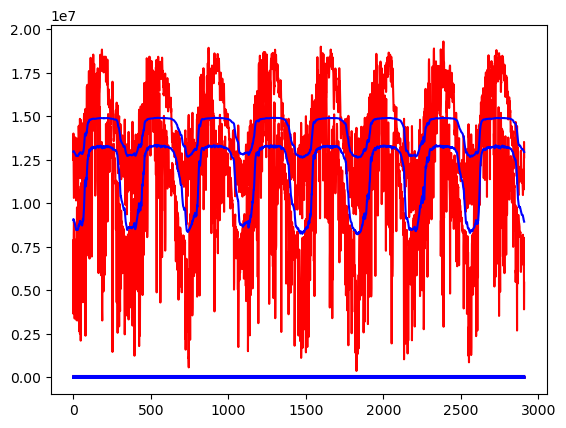

In [54]:
import matplotlib.pyplot as plt

# Assuming y_test and predictions are your actual target values and predictions tensor in their original scale after inverse transform

plt.plot(y_test_inv, color='red')
plt.plot(predictions_inv, color='blue')
plt.show()

# plt.scatter(y_test_inv, predictions_inv)
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs. Predicted Values")
# plt.show()


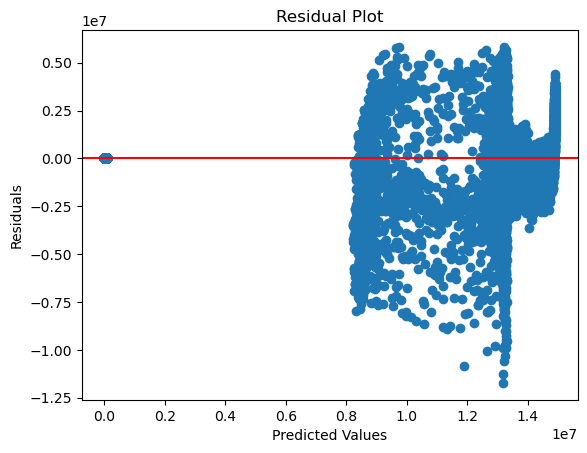

In [44]:
residuals = y_test_inv - predictions_inv

plt.scatter(predictions_inv, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.show()


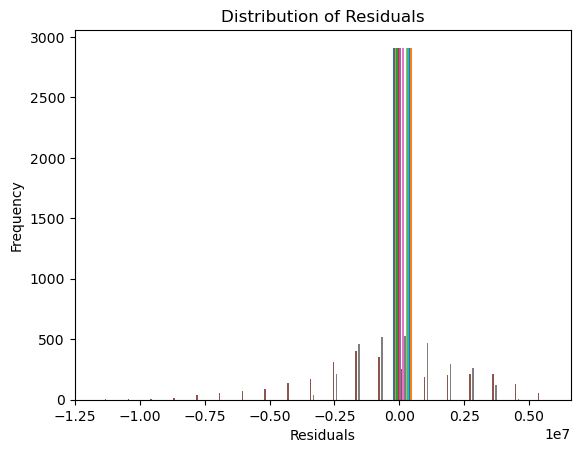

In [45]:
plt.hist(residuals, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()


In [46]:
print(data.index.shape)

(14610,)


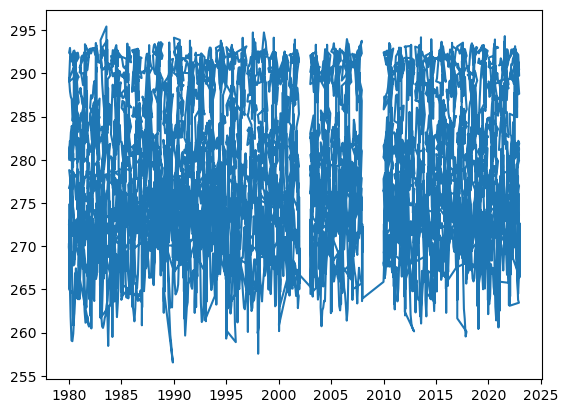

In [47]:
data2 = pd.read_csv("Rawalakot_data_1980_2022.csv")
# Convert the 'date' column to datetime
data2['date'] = pd.to_datetime(data2['date'])
plt.plot(data2['date'],data2[data2.columns[1]])

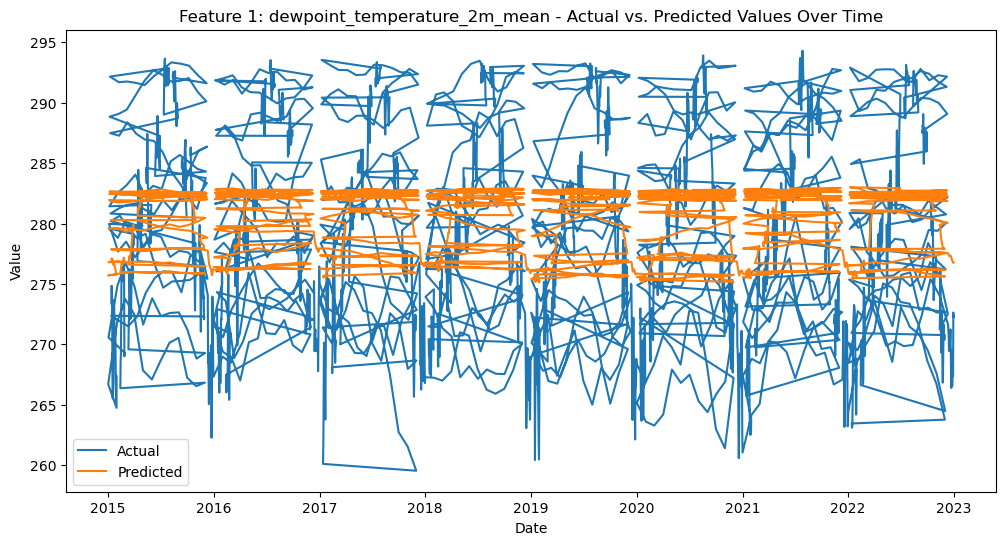

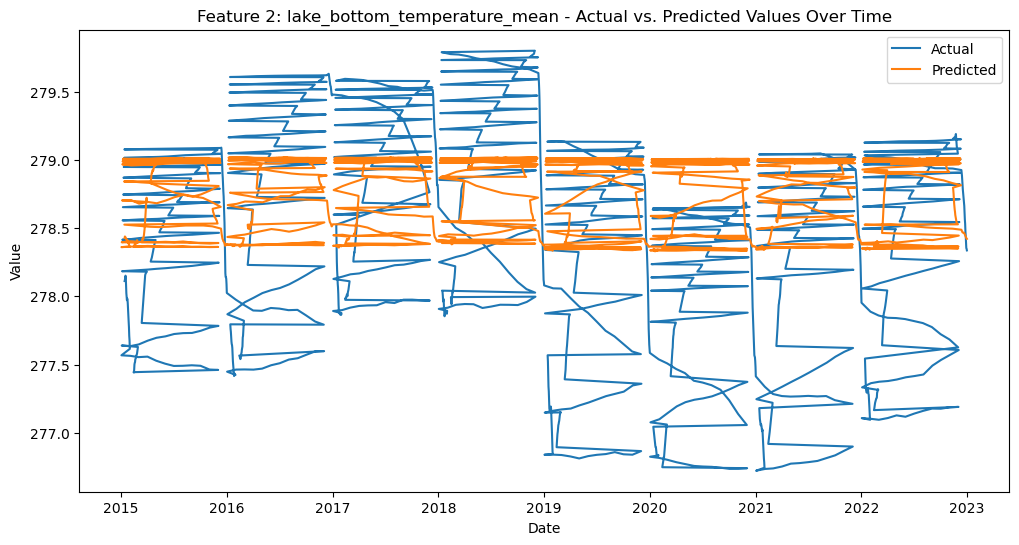

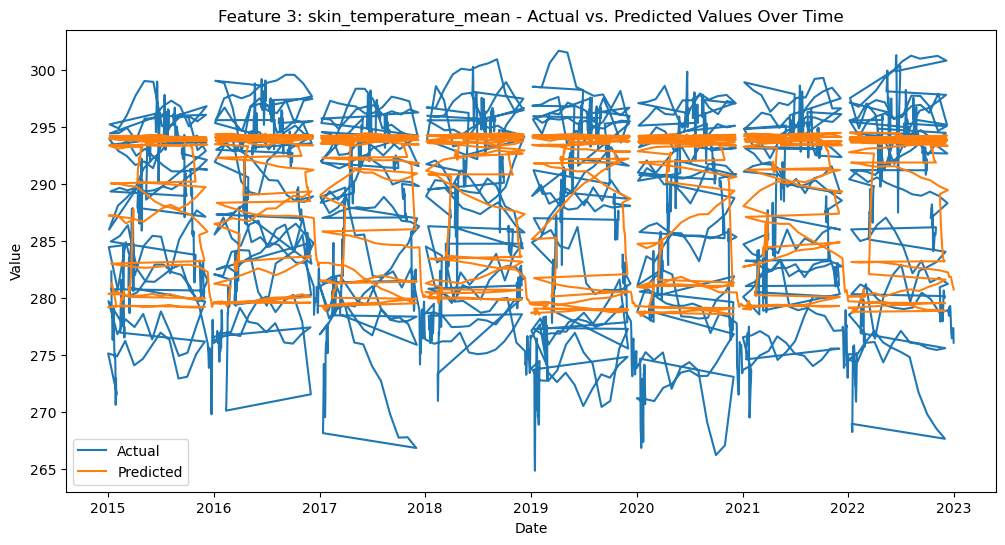

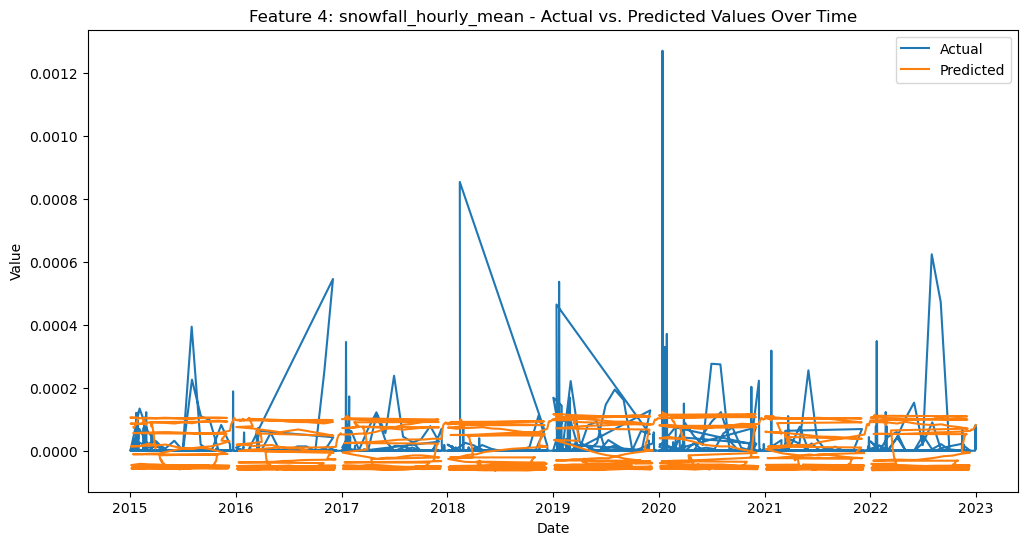

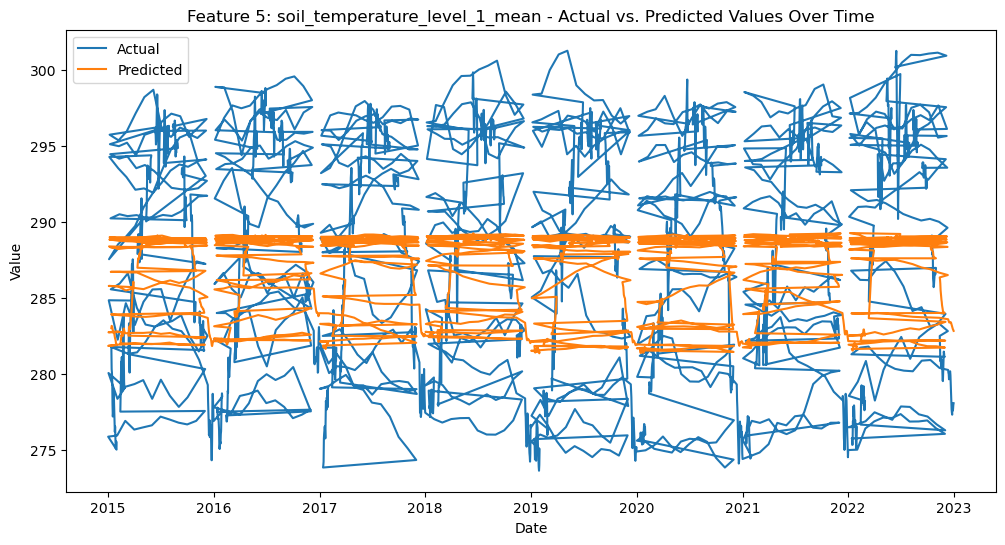

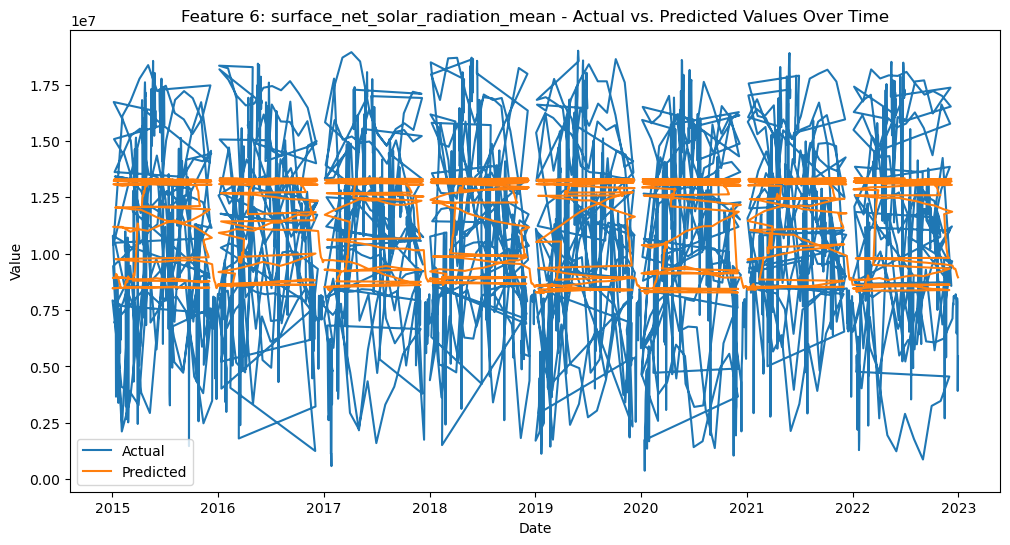

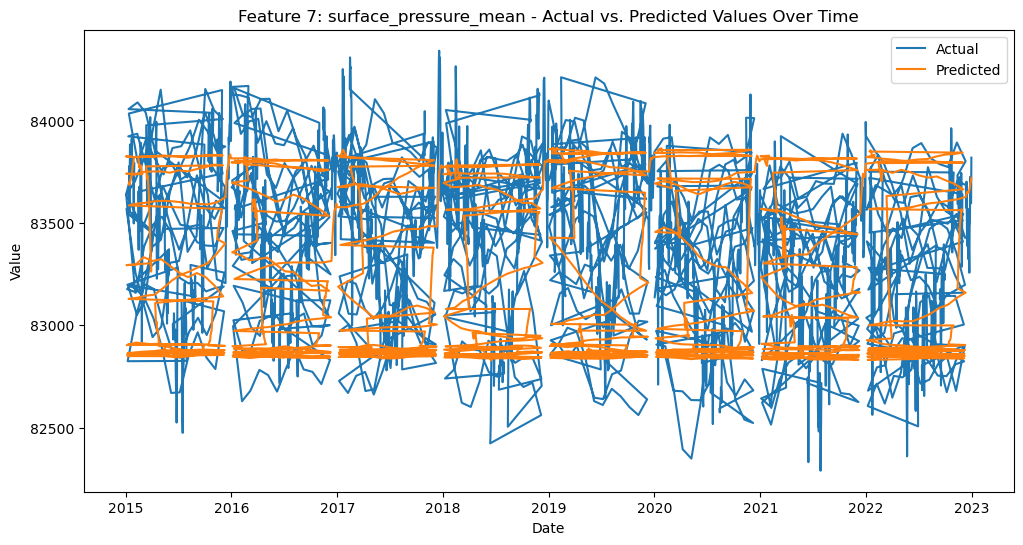

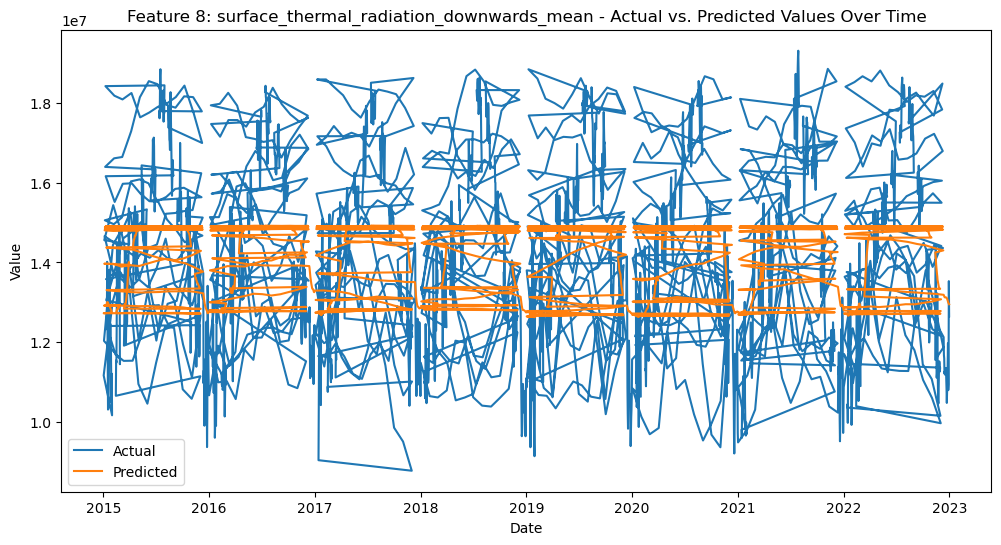

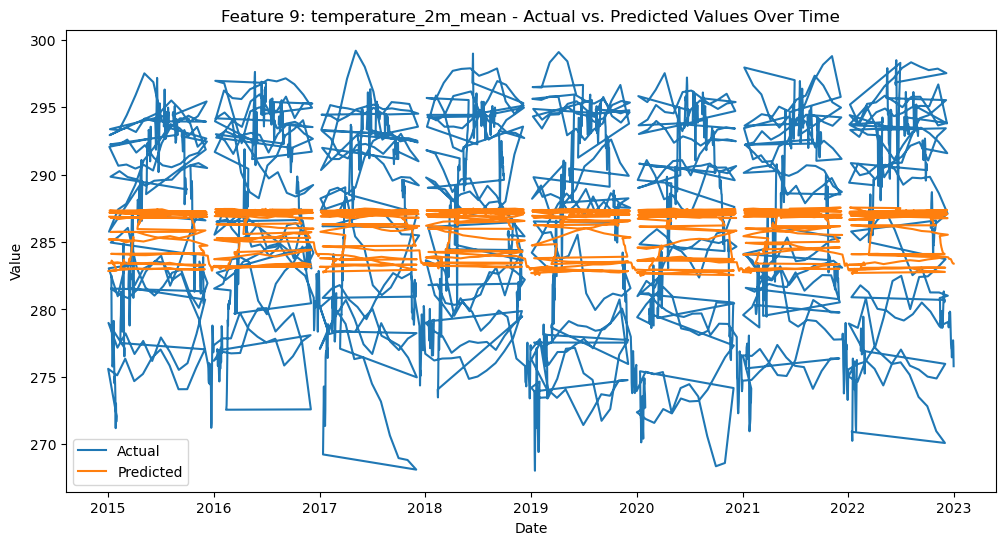

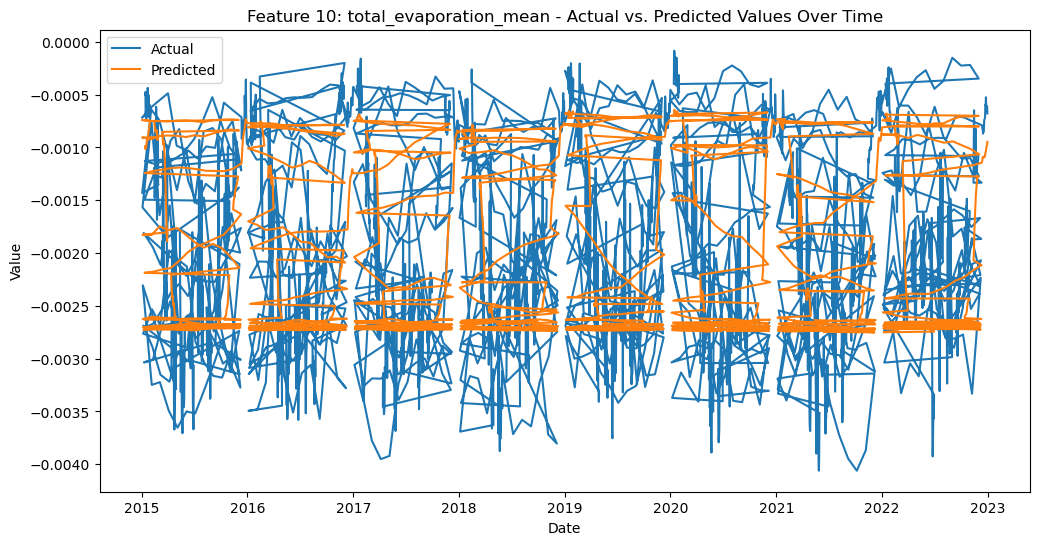

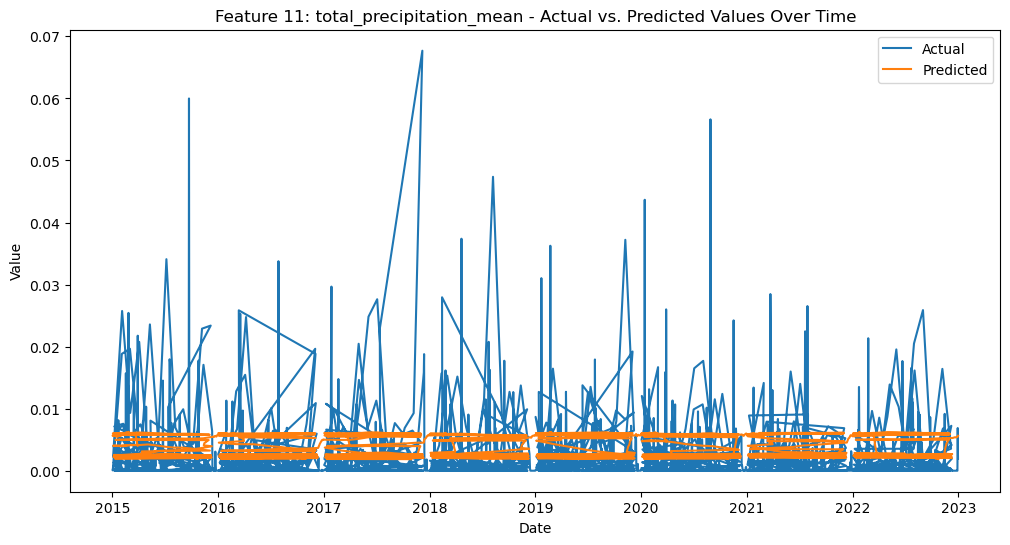

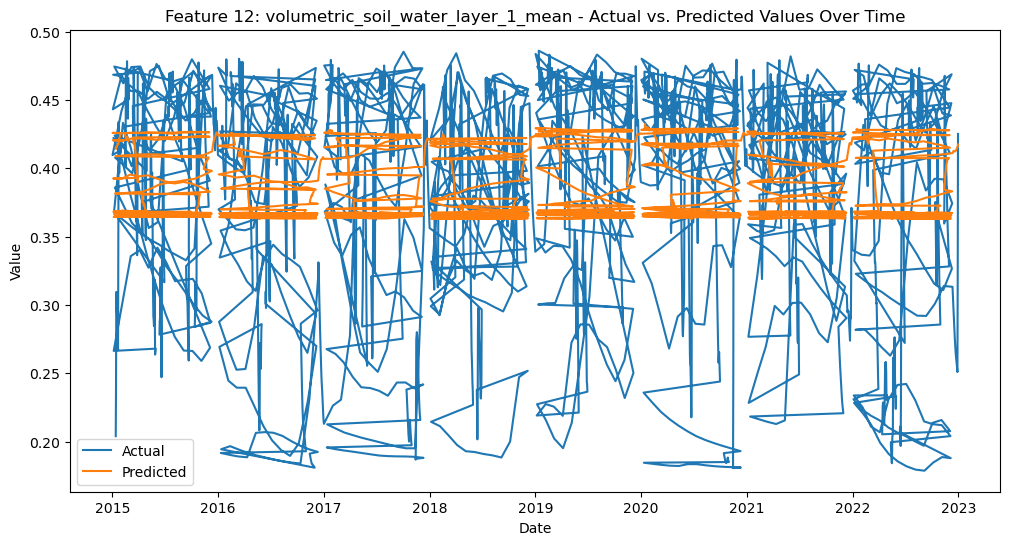

In [48]:
# Plotting y_test_inv vs. date and predictions_inv vs. date
import matplotlib.pyplot as plt

# Assuming data.index is a DatetimeIndex
test_dates = data.index[split+sequence_length+1:]

# Assuming you have a list of feature names
feature_names = list(data.columns)

# Plotting y_test_inv vs. date and predictions_inv vs. date for each input feature
num_features = X_test.shape[2]

for i in range(num_features):
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_inv[:, i], label='Actual')
    plt.plot(test_dates, predictions_inv[:, i], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Feature {i+1}: {feature_names[i]} - Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.show()


In [49]:
# # Forecasting
# future_steps = 36  # 3 years ahead, assuming monthly data
# with torch.no_grad():
#     future_seq = X_tensor[-1].unsqueeze(1)
#     for _ in range(future_steps):
#         prediction = model(future_seq)
#         future_seq = torch.cat((future_seq[1:], prediction.unsqueeze(1)), axis=0)

In [50]:
# Denormalize predictions
# predicted_data = scaler.inverse_transform(future_seq.view(-1, input_size).numpy())